In [3]:
import numpy as np
import pandas as pd
import covidecg.data.utils
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import covidecg.models.mlp_models
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from skorch.callbacks import EpochScoring, EarlyStopping


X, y = covidecg.data.utils.load_runs('../data/interim/ecg_runs.csv', '../data/interim/ecg_runs')

In [4]:
# import sklearn.svm
# import sklearn.metrics
# import covidecg.models.utils

# # models to compare
# classifiers = [
#     ('SVM (linear kernel)', sklearn.svm.SVC(kernel='linear')),
#     ('SVM (polyn. kernel)', sklearn.svm.SVC(kernel='poly')),
# ]

# fitted_classifiers = []
# for clf_name, clf in classifiers:
#     print(f"Fitting {clf_name}")
#     exp_pipe = sklearn.pipeline.make_pipeline(dataprep_pipe, clf)
#     exp_pipe.fit(X_train, y_train)
#     y_pred = exp_pipe.predict(X_test)
#     print("Balanced accuracy:", sklearn.metrics.balanced_accuracy_score(y_test, y_pred), '\n')
#     print("Confusion matrix:")
#     print(sklearn.metrics.confusion_matrix(y_test, y_pred), '\n')

In [29]:
X = X.astype(np.float32)  # TODO move to load_runs()

# pre-process targets
label_encoder = sklearn.preprocessing.LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = y_encoded.astype(np.int64) # TODO move to load_runs()

# compute class weights for CrossEntropyLoss to mitigate imbalanced classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float)

clf = NeuralNetClassifier(
    module=covidecg.models.mlp_models.MLP,
    module__input_shape=X[0].size,
    module__hidden_size=1000,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights,
    batch_size=32,
    lr=1e-4,
    optimizer__momentum=0.9,
    max_epochs=20,
    iterator_train__shuffle=True,  # Shuffle training data on each epoch
    callbacks=[
        # include additional scores into history
        EpochScoring(scoring='roc_auc', lower_is_better=False), 
        EarlyStopping(patience=3)
        ]
)

pipe = sklearn.pipeline.Pipeline([
    ('flatten_leads', sklearn.preprocessing.FunctionTransformer(func=lambda x: x.reshape(x.shape[0], -1))),
    ('clf', clf)
])
# print(pipe)

pipe.fit(X=X, y=y_encoded)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.3949        0.7801       0.2763        0.8856  9.6339
      2     0.5307        0.7069       0.5702        0.6937  8.1714
      3     0.5217        0.5937       0.5614        0.7102  8.1240
      4     0.5570        0.4877       0.6184        0.6663  8.1414
      5     0.5683        0.4305       0.6447        0.6556  7.9483
      6     0.5549        0.3998       0.6316        0.6651  7.8756
      7     0.5607        0.3854       0.6667        0.6581  8.7245
      8     0.5663        0.3754       0.6974        0.6523  8.4025
      9     0.5624        0.3697       0.6711        0.6543  8.2302
     10     0.5707        0.3655       0.7105        0.6506  7.7953
     11     0.5701        0.3618       0.7105        0.6511  7.7433
     12     0.5729        0.3597       0.7061        0.6506  8.0154
     13     0.5673        0.3578       0.6974   

Pipeline(steps=[('flatten',
                 FunctionTransformer(func=<function <lambda> at 0x7f80681224d0>)),
                ('clf',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=60000, out_features=1000, bias=True)
      (2): ReLU()
      (3): Linear(in_features=1000, out_features=1000, bias=True)
      (4): ReLU()
      (5): Linear(in_features=1000, out_features=1000, bias=True)
      (6): ReLU()
      (7): Linear(in_features=1000, out_features=1000, bias=True)
      (8): ReLU()
      (9): Linear(in_features=1000, out_features=1000, bias=True)
      (10): ReLU()
      (11): Linear(in_features=1000, out_features=2, bias=True)
      (12): Softmax(dim=-1)
    )
  ),
))])

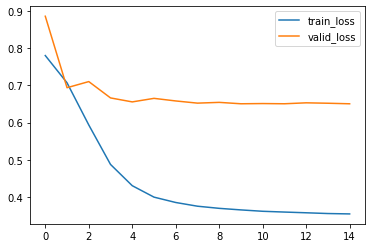

In [41]:
import matplotlib.pyplot as plt
plt.plot(clf.history[:, 'train_loss'], label='train_loss')
plt.plot(clf.history[:, 'valid_loss'], label='valid_loss')
plt.legend()
plt.show()

In [ ]:
# save model to disk
clf.save_params(f_params='model.pkl', f_optimizer='optim.pkl', f_history='history.json')

In [ ]:
# # import torch
# # import torch.nn as nn
# # from torch.utils.data import TensorDataset, DataLoader
# # import torch.optim
# # from tqdm.notebook import tqdm
# import covidecg.models.mlp_models

# torch.manual_seed(42)

# # batch_size = 128
# # learning_rate = 1e-5
# # epochs = 10

# net = covidecg.models.mlp_models.MLP(input_shape=X_train[0], hidden_size=1000)

# loss_function = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# train_ds = TensorDataset( torch.Tensor(X_train), torch.Tensor(y_train) )
# test_ds = TensorDataset( torch.Tensor(X_test), torch.Tensor(y_test) )
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)

# loss_steps = []

# # training loop
# for epoch in range(epochs):
#     current_loss = 0.0

#     for batch_i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}"), 0):
#         inputs, targets = data
#         targets = torch.Tensor(covidecg.data.utils.to_categorical(targets.numpy()))
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = loss_function(outputs, targets)
#         loss.backward()
#         optimizer.step()

#         loss_steps.append(loss.item())
#         current_loss += loss.item()

#         if batch_i % 3 == 0:
#             print(f"Epoch {epoch+1} - Batch {batch_i+1:3} - Train loss:", loss.item())

# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(loss_steps, label='train loss')
# plt.legend()
# plt.show()

In [6]:
net.eval()
y_pred = net(torch.Tensor(X_test))
y_pred = y_pred.detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
print("Balanced accuracy:", sklearn.metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision:", sklearn.metrics.precision_score(y_test, y_pred))
print("Recall:", sklearn.metrics.recall_score(y_test, y_pred))
print("Confusion matrix:")
pd.DataFrame(
    sklearn.metrics.confusion_matrix(y_test, y_pred),
    columns=label_encoder.inverse_transform([0, 1]),
    index=label_encoder.inverse_transform([0, 1])
)

Balanced accuracy: 0.5248655913978495
Precision: 0.34
Recall: 0.1827956989247312
Confusion matrix:


,covid,ctrl
covid,215,33
ctrl,76,17
